---
layout: post  
---

In [ ]:
function viterbi_maximum_likelihood_traversals(stranded_kmer_graph;
                                               error_rate::Float64=1/(stranded_kmer_graph.gprops[:k] + 1),
                                               verbosity::String="dataset")
    @assert verbosity in ["debug", "reads", "dataset"]
    if error_rate >= .5
        error("Error rate >= 50%. Did you enter the accuracy by mistake?")
    end

    if verbosity in ["debug", "reads", "dataset"]
        println("computing kmer counts...")
    end
    stranded_kmer_counts = [length(stranded_kmer_graph.vprops[vertex][:coverage]) for vertex in vertices(stranded_kmer_graph)]
    if verbosity in ["debug", "reads", "dataset"]
        println("computing kmer state likelihoods...")
    end
    stranded_kmer_likelihoods = stranded_kmer_counts ./ sum(stranded_kmer_counts)
    accuracy = 1 - error_rate

    if verbosity in ["debug"]
        println("STATE LIKELIHOODS:")
        println("\tkmer\tcount\tlikelihood")
        for vertex in vertices(stranded_kmer_graph)
            kmer = stranded_kmer_graph.gprops[:stranded_kmers][vertex]
            count = stranded_kmer_counts[vertex]
            likelihood = stranded_kmer_likelihoods[vertex]
            println("\t$kmer\t$count\t$likelihood")
        end
    end
    if verbosity in ["debug", "reads", "dataset"]
        println("finding shortest paths between kmers...")
    end
    shortest_paths = enumerate_paths(floyd_warshall_shortest_paths(stranded_kmer_graph))
    K = stranded_kmer_graph.gprops[:K]
    for K1 in 1:K
        for K2 in 1:K
            if K1 != K2
                shortest_path = shortest_paths[K1][K2]
                path_likelihood = 1.0
                for ui in 1:length(shortest_path)-1
                    u = shortest_path[ui]
                    v = shortest_path[ui + 1]
                    # likelihood of the transition
                    path_likelihood *= edge_probability(stranded_kmer_graph, Edge(u, v))
                end
                if path_likelihood == 0.0
                    shortest_paths[K1][K2] = Vector{Int}()
                end
            elseif K1 == K2
                # the shortest path from a kmer to itself is an insertion (no edge)
                # so need to manually check for self loops
                if has_edge(stranded_kmer_graph, Edge(K1, K2))
                    if edge_probability(stranded_kmer_graph, Edge(K1, K2)) != 0.0
                        shortest_paths[K1][K2] = [K1, K2]
                    else
                        shortest_paths[K1][K2] = Vector{Int}()
                    end
                # otherwise, check to see if any outneighbors connect back to the kmer
                else
                    connected_outneighbors = filter(outneighbor -> has_path(stranded_kmer_graph, outneighbor, K2), outneighbors(stranded_kmer_graph, K1))
                    if !isempty(connected_outneighbors)
                        outneighbor_cycles = [[K1, shortest_paths[outneighbor][K2]...] for outneighbor in connected_outneighbors]
                        cycle_likelihoods = ones(length(outneighbor_cycles))
                        for (i, cycle) in enumerate(outneighbor_cycles)
                            for ui in 1:length(cycle)-1
                                u = cycle[ui]
                                v = cycle[ui + 1]
                                # likelihood of the transition
                                cycle_likelihoods[i] *= edge_probability(stranded_kmer_graph, Edge(u, v))
                            end
                            # include likelihoods of states
                            for vertex in cycle[2:end-1]
                                cycle_likelihoods[i] *= stranded_kmer_likelihoods[vertex]
                            end
                        end
                        path_likelihood = maximum(cycle_likelihoods)
                        max_likelihood_cycle_indices = findall(cycle_likelihoods .== path_likelihood)
                        shortest_paths[K1][K2] = outneighbor_cycles[first(max_likelihood_cycle_indices)]
                    else
                        shortest_paths[K1][K2] = Vector{Int}()
                    end
                end
            end
            if length(shortest_paths[K1][K2]) == 1
                shortest_paths[K1][K2] = Vector{Int}()
            end
        end
    end

    if verbosity in ["debug"]
        for K1 in 1:K
            for K2 in 1:K
                println("\t$K1\t$K2\t$(shortest_paths[K1][K2])")
            end
        end
    end

    total_bases_observed = 0
    total_edits_accepted = 0

    corrected_observations = FASTA.Record[]
    if verbosity in ["debug", "reads", "dataset"]
        println("finding viterbi maximum likelihood paths for observed sequences...")
    end
    # p = Progress(length(stranded_kmer_graph.gprops[:observed_paths]))
    for (observation_index, observed_path) in enumerate(stranded_kmer_graph.gprops[:observed_paths])
        if verbosity in ["debug", "reads"]
            println("\nevaluating sequence $observation_index of $(length(stranded_kmer_graph.gprops[:observed_paths]))")
        end
        # consider switching to log transform
        kmer_likelihoods = zeros(nv(stranded_kmer_graph), length(observed_path))
        kmer_arrival_paths = Array{Vector{Int}}(undef, nv(stranded_kmer_graph), length(observed_path))
        edit_distances = zeros(Int, nv(stranded_kmer_graph), length(observed_path))
        observed_kmer_index = observed_path[1]
        observed_kmer_sequence = stranded_kmer_graph.gprops[:stranded_kmers][observed_kmer_index]
        for hidden_kmer_index in vertices(stranded_kmer_graph)
            hidden_kmer_sequence = stranded_kmer_graph.gprops[:stranded_kmers][hidden_kmer_index]
            alignment_result = pairalign(LevenshteinDistance(), observed_kmer_sequence, hidden_kmer_sequence)
            number_of_matches = count_matches(alignment(alignment_result))
            number_of_edits = stranded_kmer_graph.gprops[:k] - number_of_matches
            kmer_likelihoods[hidden_kmer_index, 1] = stranded_kmer_likelihoods[hidden_kmer_index]
            for match in 1:number_of_matches
                kmer_likelihoods[hidden_kmer_index, 1] *= accuracy
            end
            for edit in 1:number_of_edits
                kmer_likelihoods[hidden_kmer_index, 1] *= error_rate
            end
            kmer_arrival_paths[hidden_kmer_index, 1] = Vector{Int}()
            edit_distances[hidden_kmer_index, 1] = number_of_edits
        end
        kmer_likelihoods[:, 1] ./= sum(kmer_likelihoods[:, 1])
        # from here on, all probabilities are log transformed
        kmer_likelihoods[:, 1] .= log.(kmer_likelihoods[:, 1])
        if verbosity in ["debug"]
            println("\tconsidering path state 1")
            println("\t\tobserved kmer $observed_kmer_sequence")
            println("\t\tInitial state log likelihoods:")
            for line in split(repr(MIME("text/plain"), kmer_likelihoods[:, 1]), '\n')
                println("\t\t\t$line")
            end
        end
        for observed_path_index in 2:length(observed_path)
            observed_kmer_index = observed_path[observed_path_index]
            observed_base = stranded_kmer_graph.gprops[:stranded_kmers][observed_kmer_index][end]

            if verbosity in ["debug"]
                println("\tconsidering path state $observed_path_index")
                println("\t\tobserved base $observed_base")
            end

            MATCH = 1
            MISMATCH = 2
            DELETION = 3
            INSERTION = 4
            arrival_likelihoods = ones(K, 4)
            arrival_paths = fill(Vector{Int}(), K, 4)

            for K2 in 1:K
                kmer_base = stranded_kmer_graph.gprops[:stranded_kmers][K2][end]
                base_is_match = kmer_base == observed_base

                maximum_likelihood = log(0.0)
                maximum_likelihood_path = Vector{Int}()
                maximum_likelihood_edit_distance = 0

                for K1 in 1:K
                    shortest_path = shortest_paths[K1][K2]
                    if length(shortest_path) >= 2
                        edit_distance = Int(!base_is_match) + length(shortest_path) - 2
                        if edit_distance == 0
                            p = kmer_likelihoods[K1, observed_path_index-1] +
                                log(accuracy) + log(stranded_kmer_likelihoods[K2])
                        else
                            p = kmer_likelihoods[K1, observed_path_index-1] +
                                log(error_rate^edit_distance) + log(stranded_kmer_likelihoods[K2])
                        end
                        edit_distance += edit_distances[K1, observed_path_index-1]
                    else
                        p = log(0.0)
                    end
                    if K1 == K2 # consider insertion
                        # in theory, I don't think we should care if the base
                        # matches or not because it's an inserted & erroneous
                        # base, but in practice it's necessary to balance
                        # insertion probabilities with deletion probabilities
                        insertion_p = kmer_likelihoods[K1, observed_path_index-1] +
                                      log(error_rate^(1 + Int(!base_is_match))) + log(stranded_kmer_likelihoods[K2])
                        if insertion_p > p
                            p = insertion_p
                            edit_distance = edit_distances[K1, observed_path_index-1] + 1
                            shortest_path = [K2]
                        end
                    end
                    if p > maximum_likelihood
                        maximum_likelihood = p
                        maximum_likelihood_path = shortest_path
                        maximum_likelihood_edit_distance = edit_distance
                    end
                end
                kmer_likelihoods[K2, observed_path_index] = maximum_likelihood
                kmer_arrival_paths[K2, observed_path_index] = maximum_likelihood_path
                edit_distances[K2, observed_path_index] = maximum_likelihood_edit_distance
            end

            if verbosity in ["debug"]
                println("\t\tkmer log likelihoods")
                for line in split(repr(MIME("text/plain"), kmer_likelihoods), '\n')
                    println("\t\t\t$line")
                end
                println("\t\tarrival paths")
                for line in split(repr(MIME("text/plain"), kmer_arrival_paths), '\n')
                    println("\t\t\t$line")
                end
            end
        end

        if verbosity in ["debug"]
            println("\n\tInputs for viterbi maximum likelihood traversal evaluation:")
            println("\t\tkmer log likelihoods")
            for line in split(repr(MIME("text/plain"), kmer_likelihoods), '\n')
                println("\t\t\t$line")
            end
            println("\t\tkmer arrival paths")
            for line in split(repr(MIME("text/plain"), kmer_arrival_paths), '\n')
                println("\t\t\t$line")
            end
            println("\t\tedit distances")
            for line in split(repr(MIME("text/plain"), edit_distances), '\n')
                println("\t\t\t$line")
            end
        end

        ## backtrack
        maximum_likelihood_path_value = maximum(kmer_likelihoods[:, end])
        maximum_likelihood_path_indices = findall(kmer_likelihoods[:, end] .== maximum_likelihood_path_value)
        # if multiple paths are tied, randomly choose one
        maximum_likelihood_path_index = rand(maximum_likelihood_path_indices)
        maximum_likelihood_edit_distance = edit_distances[maximum_likelihood_path_index, end]

        if length(kmer_arrival_paths[maximum_likelihood_path_index, end]) > 0
            maximum_likelihood_path = last(kmer_arrival_paths[maximum_likelihood_path_index, end])
            for observed_path_index in length(observed_path):-1:1
                maximum_likelihood_arrival_path = kmer_arrival_paths[maximum_likelihood_path_index, observed_path_index]
                maximum_likelihood_path = vcat(maximum_likelihood_arrival_path[1:end-1], maximum_likelihood_path)
                maximum_likelihood_path_index = first(maximum_likelihood_path)
            end
        else
            maximum_likelihood_path = [maximum_likelihood_path_index]
        end
        observed_sequence = path_to_sequence(stranded_kmer_graph.gprops[:stranded_kmers], observed_path)
        maximum_likelihood_sequence = path_to_sequence(stranded_kmer_graph.gprops[:stranded_kmers], maximum_likelihood_path)
        if verbosity in ["debug", "reads"]
            println("\tobserved sequence                 $observed_sequence")
            println("\tmaximum likelihood sequence       $maximum_likelihood_sequence")
            println("\tmaximum likelihood edit distance  $maximum_likelihood_edit_distance")
        end
        total_bases_observed += length(observed_sequence)
        total_edits_accepted += maximum_likelihood_edit_distance
        id = stranded_kmer_graph.gprops[:observation_ids][observation_index]
        kmer_stamped_id = id * "_" * string(stranded_kmer_graph.gprops[:k])
        push!(corrected_observations, FASTA.Record(kmer_stamped_id, maximum_likelihood_sequence))
        # progress meter
        # next!(p)
    end
    if verbosity in ["debug", "reads", "dataset"]
        println("\nDATASET STATISTICS:")
        println("\tassumed error rate    $(error_rate * 100)%")
        println("\ttotal bases observed  $total_bases_observed")
        println("\ttotal edits accepted  $total_edits_accepted")
        println("\tinferred error rate   $((total_edits_accepted/total_bases_observed) * 100)%")
    end
    return corrected_observations
end

In [204]:
import Pkg
pkgs = [
    "BioSequences",
    "Random",
    "BenchmarkTools",
    "Primes",
    "LightGraphs",
    "StatsBase",
    "DataStructures",
    "GraphRecipes",
    "Plots",
    "BioSymbols",
    "StatsPlots",
    "BioAlignments",
    "SparseArrays"
]

Pkg.add(pkgs)
for pkg in pkgs
    eval(Meta.parse("import $pkg"))
end

  Resolving package versions...
Updating `~/.julia/environments/v1.5/Project.toml`
  [2f01184e] + SparseArrays
No Changes to `~/.julia/environments/v1.5/Manifest.toml`


In [6]:
K = 3

3

In [7]:
KMER_TYPE = BioSequences.DNAMer{K}

BioSequences.Mer{BioSequences.DNAAlphabet{2},3}

In [9]:
sequence = BioSequences.randdnaseq(Random.seed!(1), 10)

10nt DNA Sequence:
TCGTCCCAGG

In [207]:
function get_kmer_counts(::Type{KMER_TYPE}, sequence) where KMER_TYPE
    raw_kmer_counts = StatsBase.countmap(BioSequences.canonical(kmer.fw) for kmer in BioSequences.each(KMER_TYPE, sequence))
    kmer_counts = convert(Dict{KMER_TYPE, Int}, raw_kmer_counts)
    return sort(kmer_counts)
end

get_kmer_counts (generic function with 1 method)

In [208]:
kmer_counts = get_kmer_counts(KMER_TYPE, sequence)

OrderedCollections.OrderedDict{BioSequences.Mer{BioSequences.DNAAlphabet{2},3},Int64} with 8 entries:
  ACG => 1
  AGG => 1
  CAG => 1
  CCA => 1
  CCC => 1
  CGA => 1
  GAC => 1
  GGA => 1

In [209]:
graph = LightGraphs.SimpleGraph(length(kmer_counts))

{8, 0} undirected simple Int64 graph

In [210]:
kmers = collect(keys(kmer_counts))

8-element Array{BioSequences.Mer{BioSequences.DNAAlphabet{2},3},1}:
 ACG
 AGG
 CAG
 CCA
 CCC
 CGA
 GAC
 GGA

In [211]:
function get_kmer_index(kmers, kmer)
    index_range = searchsorted(kmers, kmer)
    if !isempty(index_range)
        return first(index_range)
    else
        return nothing
    end
end

get_kmer_index (generic function with 1 method)

In [212]:
for i in 1:length(sequence)-K
    a_to_b_connection = sequence[i:i+K]
    a = BioSequences.canonical(BioSequences.DNAMer(a_to_b_connection[1:end-1]))
    b = BioSequences.canonical(BioSequences.DNAMer(a_to_b_connection[2:end]))
    a_index = get_kmer_index(kmers, a)
    b_index = get_kmer_index(kmers, b)
    edge = LightGraphs.Edge(a_index, b_index)
    LightGraphs.add_edge!(graph, edge)
end

In [213]:
graph

{8, 7} undirected simple Int64 graph

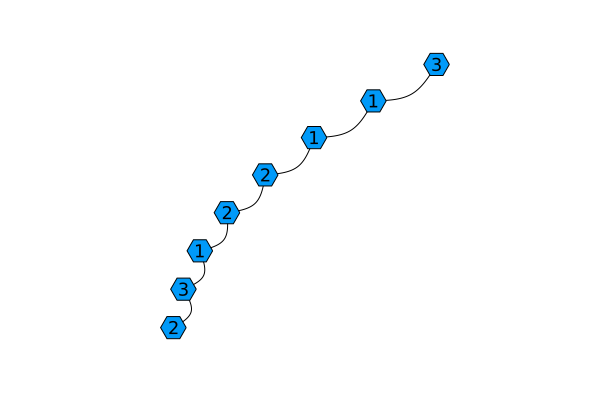

![](/assets/images/2826433329163121736.svg)

In [214]:
graph_hash = hash(sort(graph.fadjlist), hash(graph.ne))

p = GraphRecipes.graphplot(
    graph,
    names = 1:K,
    markersize = 0.15,
    hover=false,
    fontsize=12)

filename = "/assets/images/$(graph_hash).svg"
Plots.savefig(p, dirname(pwd()) * filename)
display(p)
display("text/markdown", "![]($filename)")

In [215]:
function observe(sequence; error_rate = error_rate, alphabet = BioSymbols.ACGT)
    new_seq = Vector{eltype(sequence)}()
    for character in sequence
        if rand() > error_rate
            # match
            push!(new_seq, character)
        else
            error_type = rand(1:3)
            if error_type == 1
                # mismatch
                push!(new_seq, rand(setdiff(alphabet, character)))
            elseif error_type == 2
                # insertion
                push!(new_seq, rand(alphabet))
                push!(new_seq, character)
            else
                # deletion
                continue
            end
        end
    end
    return_seq = BioSequences.LongDNASeq(new_seq)
    if rand(Bool)
        return_seq = BioSequences.reverse_complement!(return_seq)
    end
    return return_seq
end

observe (generic function with 1 method)

In [350]:
error_rate = 0.05

0.05

In [351]:
observations = [observe(sequence, error_rate = error_rate) for i in 1:10]

10-element Array{BioSequences.LongSequence{BioSequences.DNAAlphabet{4}},1}:
 CCTGGGACGA
 TCGTCCCAGG
 CCTAGGGATCA
 TCGTCCCAGG
 CCTGGGACGA
 TCGTCCCAGG
 CCTTGGGACGA
 TCGTCTCAGG
 TCGTCCCAGG
 TCGTCCCAGG

In [352]:
kmer_counts = sort!(merge!(+, collect(get_kmer_counts(KMER_TYPE, sequence) for sequence in observations)...))

OrderedCollections.OrderedDict{BioSequences.Mer{BioSequences.DNAAlphabet{2},3},Int64} with 15 entries:
  AAG => 1
  ACG => 9
  AGA => 1
  AGG => 11
  ATC => 2
  CAA => 1
  CAG => 8
  CCA => 8
  CCC => 9
  CGA => 9
  CTA => 2
  CTC => 1
  GAC => 9
  GGA => 9
  TCA => 2

In [353]:
kmer_counts_hist = StatsBase.countmap(v for v in values(kmer_counts))

Dict{Any,Int64} with 5 entries:
  9  => 5
  2  => 3
  11 => 1
  8  => 2
  1  => 4

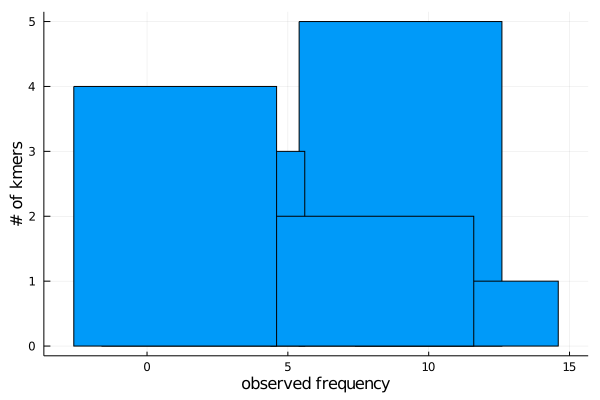

In [354]:
StatsPlots.plot(
    collect(keys(kmer_counts_hist)),
    collect(values(kmer_counts_hist)),
    seriestype = :bar,
    legend = false,
    xlabel = "observed frequency",
    ylabel = "# of kmers"
)

In [355]:
graph = LightGraphs.SimpleGraph(length(kmer_counts))

{15, 0} undirected simple Int64 graph

In [356]:
kmers = collect(keys(kmer_counts))

15-element Array{BioSequences.Mer{BioSequences.DNAAlphabet{2},3},1}:
 AAG
 ACG
 AGA
 AGG
 ATC
 CAA
 CAG
 CCA
 CCC
 CGA
 CTA
 CTC
 GAC
 GGA
 TCA

In [520]:
counts = collect(values(kmer_counts))

15-element Array{Int64,1}:
  1
  9
  1
 11
  2
  1
  8
  8
  9
  9
  2
  1
  9
  9
  2

In [359]:
function ordered_edge(a, b)
    if a <= b
        return LightGraphs.Edge(a, b)
    else
        return LightGraphs.Edge(b, a)
    end
end

ordered_edge (generic function with 1 method)

In [363]:
EDGE_TYPE = LightGraphs.SimpleGraphs.SimpleEdge{Int64}
EVIDENCE_TYPE = NamedTuple{(:sequence_index, :edge_index),Tuple{Int64,Int64}}
edge_evidence = Dict{EDGE_TYPE, Vector{EVIDENCE_TYPE}}()
for (sequence_index, sequence) in enumerate(observations)
    for edge_index in 1:length(sequence)-K
        a_to_b_connection = sequence[edge_index:edge_index+K]
        a = BioSequences.canonical(BioSequences.DNAMer(a_to_b_connection[1:end-1]))
        b = BioSequences.canonical(BioSequences.DNAMer(a_to_b_connection[2:end]))
        a_index = get_kmer_index(kmers, a)
        b_index = get_kmer_index(kmers, b)
        edge = ordered_edge(a_index, b_index)
        LightGraphs.add_edge!(graph, edge)
        evidence = (;sequence_index, edge_index)
        edge_evidence[edge] = push!(get(edge_evidence, edge, EVIDENCE_TYPE[]), evidence)
    end
end

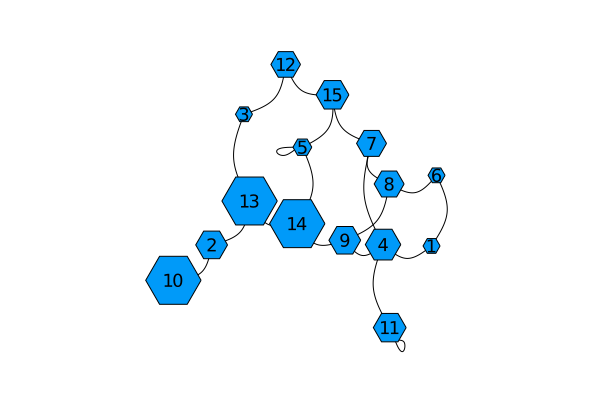

![](/assets/images/15129024089579920886.svg)

In [364]:
graph_hash = hash(sort(graph.fadjlist), hash(graph.ne))

p = GraphRecipes.graphplot(
    graph,
    names = 1:length(kmers),
    node_weights = collect(values(kmer_counts)),
    markersize = 0.2,
    hover=false,
    fontsize=12)

filename = "/assets/images/$(graph_hash).svg"
Plots.savefig(p, dirname(pwd()) * filename)
display(p)
display("text/markdown", "![]($filename)")

In [365]:
function determine_edge_probabilities(graph, kmers, edge_evidence)
    outgoing_edge_probabilities = determine_edge_probabilities(graph, kmers, edge_evidence, true)
    incoming_edge_probabilities = determine_edge_probabilities(graph, kmers, edge_evidence, false)
    return outgoing_edge_probabilities, incoming_edge_probabilities
end

function determine_edge_probabilities(graph, kmers, edge_evidence, strand)
    outgoing_edge_probabilities = SparseArrays.spzeros(length(kmers), length(kmers))
    for (kmer_index, kmer) in enumerate(kmers)
        if !strand
            kmer = BioSequences.reverse_complement(kmer)
        end
        
        downstream_neighbor_indices = Union{Nothing, Int}[
            get_kmer_index(kmers, BioSequences.canonical(neighbor)) for neighbor in BioSequences.neighbors(kmer)
        ]
        filter!(neighbor_index -> neighbor_index != nothing, downstream_neighbor_indices)
        sort!(downstream_neighbor_indices)
        
        downstream_edge_weights = Int[
            length(get(edge_evidence, ordered_edge(kmer_index, neighbor_index), [])) for neighbor_index in downstream_neighbor_indices
        ]
        
        non_zero_indices = downstream_edge_weights .> 0
        downstream_neighbor_indices = downstream_neighbor_indices[non_zero_indices]
        downstream_edge_weights = downstream_edge_weights[non_zero_indices]
        
        downstream_edge_likelihoods = downstream_edge_weights ./ sum(downstream_edge_weights)
        for (neighbor_index, likelihood) in zip(downstream_neighbor_indices, downstream_edge_likelihoods)
            outgoing_edge_probabilities[kmer_index, neighbor_index] = likelihood
        end
    end
    return outgoing_edge_probabilities
end

determine_edge_probabilities (generic function with 3 methods)

In [366]:
outgoing_edge_probabilities, incoming_edge_probabilities = determine_edge_probabilities(graph, kmers, edge_evidence)

(
  [6 ,  1]  =  1.0
  [13,  2]  =  1.0
  [12,  3]  =  0.5
  [1 ,  4]  =  1.0
  [7 ,  4]  =  1.0
  [9 ,  4]  =  0.111111
  [14,  5]  =  0.111111
  [8 ,  6]  =  0.125
  [8 ,  7]  =  0.875
  [15,  7]  =  1.0
  [9 ,  8]  =  0.888889
  [4 ,  9]  =  1.0
  [2 , 10]  =  1.0
  [11, 11]  =  1.0
  [3 , 12]  =  0.5
  [3 , 13]  =  0.5
  [14, 13]  =  0.888889
  [5 , 14]  =  0.5
  [5 , 15]  =  0.5
  [12, 15]  =  0.5, 
  [4 ,  1]  =  0.0909091
  [10,  2]  =  1.0
  [12,  3]  =  1.0
  [13,  3]  =  0.111111
  [11,  4]  =  1.0
  [5 ,  5]  =  1.0
  [15,  5]  =  0.5
  [1 ,  6]  =  1.0
  [4 ,  7]  =  0.727273
  [6 ,  8]  =  1.0
  [7 ,  8]  =  0.875
  [8 ,  9]  =  1.0
  [14,  9]  =  1.0
  [4 , 11]  =  0.181818
  [3 , 12]  =  1.0
  [15, 12]  =  0.5
  [2 , 13]  =  1.0
  [9 , 14]  =  1.0
  [13, 14]  =  0.888889
  [7 , 15]  =  0.125)

In [367]:
shortest_paths = LightGraphs.enumerate_paths(LightGraphs.floyd_warshall_shortest_paths(graph))

15-element Array{Array{Array{Int64,1},1},1}:
 [[], [1, 4, 9, 14, 13, 2], [1, 4, 9, 14, 13, 3], [1, 4], [1, 4, 9, 14, 5], [1, 6], [1, 4, 7], [1, 6, 8], [1, 4, 9], [1, 4, 9, 14, 13, 2, 10], [1, 4, 11], [1, 4, 7, 15, 12], [1, 4, 9, 14, 13], [1, 4, 9, 14], [1, 4, 7, 15]]
 [[2, 13, 14, 9, 4, 1], [], [2, 13, 3], [2, 13, 14, 9, 4], [2, 13, 14, 5], [2, 13, 14, 9, 8, 6], [2, 13, 14, 9, 4, 7], [2, 13, 14, 9, 8], [2, 13, 14, 9], [2, 10], [2, 13, 14, 9, 4, 11], [2, 13, 3, 12], [2, 13], [2, 13, 14], [2, 13, 3, 12, 15]]
 [[3, 13, 14, 9, 4, 1], [3, 13, 2], [], [3, 13, 14, 9, 4], [3, 13, 14, 5], [3, 13, 14, 9, 8, 6], [3, 12, 15, 7], [3, 13, 14, 9, 8], [3, 13, 14, 9], [3, 13, 2, 10], [3, 13, 14, 9, 4, 11], [3, 12], [3, 13], [3, 13, 14], [3, 12, 15]]
 [[4, 1], [4, 9, 14, 13, 2], [4, 9, 14, 13, 3], [], [4, 9, 14, 5], [4, 1, 6], [4, 7], [4, 7, 8], [4, 9], [4, 9, 14, 13, 2, 10], [4, 11], [4, 7, 15, 12], [4, 9, 14, 13], [4, 9, 14], [4, 7, 15]]
 [[5, 14, 9, 4, 1], [5, 14, 13, 2], [5, 14, 13, 3], [5, 14, 9, 4

In [701]:
observation = first(observations)

10nt DNA Sequence:
CCTGGGACGA

In [702]:
ORIENTED_KMER = NamedTuple{(:index, :observed_canonically),Tuple{Int64,Bool}}

NamedTuple{(:index, :observed_canonically),Tuple{Int64,Bool}}

In [703]:
observed_path = [
    (index = get_kmer_index(kmers, BioSequences.canonical(kmer.fw)),
     observed_canonically = kmer.fw < kmer.bw) 
    for kmer in BioSequences.each(KMER_TYPE, observation)]

8-element Array{NamedTuple{(:index, :observed_canonically),Tuple{Int64,Bool}},1}:
 (index = 4, observed_canonically = 0)
 (index = 7, observed_canonically = 0)
 (index = 8, observed_canonically = 0)
 (index = 9, observed_canonically = 0)
 (index = 14, observed_canonically = 1)
 (index = 13, observed_canonically = 1)
 (index = 2, observed_canonically = 1)
 (index = 10, observed_canonically = 1)

In [704]:
# kmer_likelihoods = zeros(LightGraphs.nv(graph), length(observed_path))
kmer_likelihoods = Array{Float64}(undef, LightGraphs.nv(graph), length(observed_path)) .= -Inf

15×8 Array{Float64,2}:
 -Inf  -Inf  -Inf  -Inf  -Inf  -Inf  -Inf  -Inf
 -Inf  -Inf  -Inf  -Inf  -Inf  -Inf  -Inf  -Inf
 -Inf  -Inf  -Inf  -Inf  -Inf  -Inf  -Inf  -Inf
 -Inf  -Inf  -Inf  -Inf  -Inf  -Inf  -Inf  -Inf
 -Inf  -Inf  -Inf  -Inf  -Inf  -Inf  -Inf  -Inf
 -Inf  -Inf  -Inf  -Inf  -Inf  -Inf  -Inf  -Inf
 -Inf  -Inf  -Inf  -Inf  -Inf  -Inf  -Inf  -Inf
 -Inf  -Inf  -Inf  -Inf  -Inf  -Inf  -Inf  -Inf
 -Inf  -Inf  -Inf  -Inf  -Inf  -Inf  -Inf  -Inf
 -Inf  -Inf  -Inf  -Inf  -Inf  -Inf  -Inf  -Inf
 -Inf  -Inf  -Inf  -Inf  -Inf  -Inf  -Inf  -Inf
 -Inf  -Inf  -Inf  -Inf  -Inf  -Inf  -Inf  -Inf
 -Inf  -Inf  -Inf  -Inf  -Inf  -Inf  -Inf  -Inf
 -Inf  -Inf  -Inf  -Inf  -Inf  -Inf  -Inf  -Inf
 -Inf  -Inf  -Inf  -Inf  -Inf  -Inf  -Inf  -Inf

In [705]:
edit_distances = zeros(Int, LightGraphs.nv(graph), length(observed_path))

15×8 Array{Int64,2}:
 0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0

In [706]:
arrival_paths = Array{Vector{ORIENTED_KMER}}(undef, LightGraphs.nv(graph), length(observed_path))

15×8 Array{Array{NamedTuple{(:index, :observed_canonically),Tuple{Int64,Bool}},1},2}:
 #undef  #undef  #undef  #undef  #undef  #undef  #undef  #undef
 #undef  #undef  #undef  #undef  #undef  #undef  #undef  #undef
 #undef  #undef  #undef  #undef  #undef  #undef  #undef  #undef
 #undef  #undef  #undef  #undef  #undef  #undef  #undef  #undef
 #undef  #undef  #undef  #undef  #undef  #undef  #undef  #undef
 #undef  #undef  #undef  #undef  #undef  #undef  #undef  #undef
 #undef  #undef  #undef  #undef  #undef  #undef  #undef  #undef
 #undef  #undef  #undef  #undef  #undef  #undef  #undef  #undef
 #undef  #undef  #undef  #undef  #undef  #undef  #undef  #undef
 #undef  #undef  #undef  #undef  #undef  #undef  #undef  #undef
 #undef  #undef  #undef  #undef  #undef  #undef  #undef  #undef
 #undef  #undef  #undef  #undef  #undef  #undef  #undef  #undef
 #undef  #undef  #undef  #undef  #undef  #undef  #undef  #undef
 #undef  #undef  #undef  #undef  #undef  #undef  #undef  #undef
 #undef  #undef  #

In [707]:
function assess_alignment(a, b)
    pairwise_alignment = BioAlignments.pairalign(BioAlignments.LevenshteinDistance(), a, b)
    alignment_result = BioAlignments.alignment(pairwise_alignment)
    total_aligned_bases = BioAlignments.count_aligned(alignment_result)
    total_matches = BioAlignments.count_matches(alignment_result)
    total_edits = total_aligned_bases - total_matches
    return (;total_matches, total_edits)
end

assess_alignment (generic function with 1 method)

# initialization

In [708]:
observed_kmer = observed_path[1]

(index = 4, observed_canonically = false)

In [709]:
kmer_likelihoods[:, 1] .= counts ./ sum(counts)

15-element view(::Array{Float64,2}, :, 1) with eltype Float64:
 0.012195121951219513
 0.10975609756097561
 0.012195121951219513
 0.13414634146341464
 0.024390243902439025
 0.012195121951219513
 0.0975609756097561
 0.0975609756097561
 0.10975609756097561
 0.10975609756097561
 0.024390243902439025
 0.012195121951219513
 0.10975609756097561
 0.10975609756097561
 0.024390243902439025

In [710]:
for (kmer_index, kmer) in enumerate(kmers)
    alignment_result = assess_alignment(kmers[observed_kmer.index], kmer)
    for match in 1:alignment_result.total_matches
        kmer_likelihoods[kmer_index, 1] *= accuracy
    end
    for edit in 1:alignment_result.total_edits
        kmer_likelihoods[kmer_index, 1] *= error_rate
    end
    arrival_paths[kmer_index, 1] = [observed_kmer]
    edit_distances[kmer_index, 1] = alignment_result.total_edits
end

In [711]:
kmer_likelihoods ./= sum(kmer_likelihoods[:, 1])

15×8 Array{Float64,2}:
 0.00474711   -Inf  -Inf  -Inf  -Inf  -Inf  -Inf  -Inf
 0.042724     -Inf  -Inf  -Inf  -Inf  -Inf  -Inf  -Inf
 0.00474711   -Inf  -Inf  -Inf  -Inf  -Inf  -Inf  -Inf
 0.939929     -Inf  -Inf  -Inf  -Inf  -Inf  -Inf  -Inf
 0.000527457  -Inf  -Inf  -Inf  -Inf  -Inf  -Inf  -Inf
 1.46516e-5   -Inf  -Inf  -Inf  -Inf  -Inf  -Inf  -Inf
 0.00210983   -Inf  -Inf  -Inf  -Inf  -Inf  -Inf  -Inf
 0.000117213  -Inf  -Inf  -Inf  -Inf  -Inf  -Inf  -Inf
 0.000131864  -Inf  -Inf  -Inf  -Inf  -Inf  -Inf  -Inf
 0.00237356   -Inf  -Inf  -Inf  -Inf  -Inf  -Inf  -Inf
 2.93032e-5   -Inf  -Inf  -Inf  -Inf  -Inf  -Inf  -Inf
 1.46516e-5   -Inf  -Inf  -Inf  -Inf  -Inf  -Inf  -Inf
 0.000131864  -Inf  -Inf  -Inf  -Inf  -Inf  -Inf  -Inf
 0.00237356   -Inf  -Inf  -Inf  -Inf  -Inf  -Inf  -Inf
 2.93032e-5   -Inf  -Inf  -Inf  -Inf  -Inf  -Inf  -Inf

In [712]:
kmer_likelihoods[:, 1] .= log.(kmer_likelihoods[:, 1])

15-element view(::Array{Float64,2}, :, 1) with eltype Float64:
  -5.350218500854826
  -3.1529939235186064
  -5.350218500854826
  -0.06195147016029066
  -7.547443078191045
 -11.130962016647155
  -6.161148717071154
  -9.051520474967319
  -8.933737439310935
  -6.043365681414771
 -10.43781483608721
 -11.130962016647155
  -8.933737439310935
  -6.043365681414771
 -10.43781483608721

In [713]:
display(kmer_likelihoods)
display(arrival_paths)
display(edit_distances)

15×8 Array{Float64,2}:
  -5.35022    -Inf  -Inf  -Inf  -Inf  -Inf  -Inf  -Inf
  -3.15299    -Inf  -Inf  -Inf  -Inf  -Inf  -Inf  -Inf
  -5.35022    -Inf  -Inf  -Inf  -Inf  -Inf  -Inf  -Inf
  -0.0619515  -Inf  -Inf  -Inf  -Inf  -Inf  -Inf  -Inf
  -7.54744    -Inf  -Inf  -Inf  -Inf  -Inf  -Inf  -Inf
 -11.131      -Inf  -Inf  -Inf  -Inf  -Inf  -Inf  -Inf
  -6.16115    -Inf  -Inf  -Inf  -Inf  -Inf  -Inf  -Inf
  -9.05152    -Inf  -Inf  -Inf  -Inf  -Inf  -Inf  -Inf
  -8.93374    -Inf  -Inf  -Inf  -Inf  -Inf  -Inf  -Inf
  -6.04337    -Inf  -Inf  -Inf  -Inf  -Inf  -Inf  -Inf
 -10.4378     -Inf  -Inf  -Inf  -Inf  -Inf  -Inf  -Inf
 -11.131      -Inf  -Inf  -Inf  -Inf  -Inf  -Inf  -Inf
  -8.93374    -Inf  -Inf  -Inf  -Inf  -Inf  -Inf  -Inf
  -6.04337    -Inf  -Inf  -Inf  -Inf  -Inf  -Inf  -Inf
 -10.4378     -Inf  -Inf  -Inf  -Inf  -Inf  -Inf  -Inf

15×8 Array{Array{NamedTuple{(:index, :observed_canonically),Tuple{Int64,Bool}},1},2}:
 [(index = 4, observed_canonically = 0)]  …  #undef  #undef  #undef  #undef
 [(index = 4, observed_canonically = 0)]     #undef  #undef  #undef  #undef
 [(index = 4, observed_canonically = 0)]     #undef  #undef  #undef  #undef
 [(index = 4, observed_canonically = 0)]     #undef  #undef  #undef  #undef
 [(index = 4, observed_canonically = 0)]     #undef  #undef  #undef  #undef
 [(index = 4, observed_canonically = 0)]  …  #undef  #undef  #undef  #undef
 [(index = 4, observed_canonically = 0)]     #undef  #undef  #undef  #undef
 [(index = 4, observed_canonically = 0)]     #undef  #undef  #undef  #undef
 [(index = 4, observed_canonically = 0)]     #undef  #undef  #undef  #undef
 [(index = 4, observed_canonically = 0)]     #undef  #undef  #undef  #undef
 [(index = 4, observed_canonically = 0)]  …  #undef  #undef  #undef  #undef
 [(index = 4, observed_canonically = 0)]     #undef  #undef  #undef  #undef
 [

15×8 Array{Int64,2}:
 1  0  0  0  0  0  0  0
 1  0  0  0  0  0  0  0
 1  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0
 2  0  0  0  0  0  0  0
 3  0  0  0  0  0  0  0
 2  0  0  0  0  0  0  0
 3  0  0  0  0  0  0  0
 3  0  0  0  0  0  0  0
 2  0  0  0  0  0  0  0
 3  0  0  0  0  0  0  0
 3  0  0  0  0  0  0  0
 3  0  0  0  0  0  0  0
 2  0  0  0  0  0  0  0
 3  0  0  0  0  0  0  0

In [714]:
function assess_path_orientations(path, kmers, initial_orientation)
    orientations = trues(length(path))
    for (i, (a, b)) in enumerate(zip(path[1:end-1], path[2:end]))
        kmer_a = kmers[a]
        kmer_b = kmers[b]
        this_orientation = true
        for (a_index, b_index) in zip(2:length(kmer_a), 1:length(kmer_b)-1)
            this_orientation &= kmer_a[a_index] == kmer_b[b_index]
        end
        orientations[i+1] = this_orientation
    end
    if !initial_orientation
        orientations = .!orientations
    end
    return orientations
end

assess_path_orientations (generic function with 2 methods)

In [715]:
function assess_transition_likelihood(oriented_path, kmers, counts, outgoing_edge_probabilities, incoming_edge_probabilities)
    likelihood = 1.0
    intermediate_nodes = oriented_path[2:end-1]
    for node in intermediate_nodes
        likelihood *= counts[node.index] / sum(counts)
    end
    for (a, b) in zip(path[1:end-1], path[2:end])
        if a.observed_canonically
            likelihood *= outgoing_edge_probabilities[a.index, b.index]
        else
            likelihood *= incoming_edge_probabilities[a.index, b.index]
        end
    end
    return likelihood
end

assess_transition_likelihood (generic function with 2 methods)

In [716]:
function orient_path(path, orientations)
    oriented_path = [(index = i, observed_canonically = o) for (i, o) in zip(path, orientations)] 
    return oriented_path
end

orient_path (generic function with 1 method)

In [717]:
function find_optimal_path(observed_kmer,
    previous_kmer_index, 
    current_kmer_index, 
    graph, 
    shortest_paths, 
    kmers, 
    counts, 
    outgoing_edge_probabilities, 
    incoming_edge_probabilities)

    # we've already paid the cost of all previous errors, so only evaluate new base
    is_match = kmers[observed_kmer.index][end] == hidden_kmer[end]
    if is_match
        emission_likelihood = accuracy
    else
        emission_likelihood = error_rate
    end

    state_likelihood = counts[observed_kmer.index] / total_kmer_count

    transition_likelihood = 0.0
    oriented_path = Vector{ORIENTED_KMER}()

    if current_kmer_index == previous_kmer_index
        # default expectation is that it's a deletion
        transition_likelihood = error_rate

        # could be true connection, switch to this if it's more likely
        if LightGraphs.has_edge(graph, LightGraphs.Edge(previous_kmer_index, current_kmer_index))
            this_path = [previous_kmer_index, current_kmer_index]
            this_oriented_path = orient_path(this_path, assess_path_orientations(this_path, kmers, observed_kmer.observed_canonically))            
            this_likelihood = assess_transition_likelihood(this_oriented_path, kmers, counts, outgoing_edge_probabilities, incoming_edge_probabilities)
            if this_likelihood > transition_likelihood
                transition_likelihood = this_likelihood
                oriented_path = this_oriented_path
            end
        end

        # could also be an insertion
        # see if this has any neighbors that circle back, and evaluate the likelihood for each
        if observed_kmer.observed_canonically
            outneighbors = first(SparseArrays.findnz(outgoing_edge_probabilities[current_kmer_index, :]))
        else
            outneighbors = first(SparseArrays.findnz(incoming_edge_probabilities[current_kmer_index, :]))
        end
#         @show outneighbors
        for outneighbor in outneighbors
            if LightGraphs.has_path(graph, outneighbor, current_kmer_index)
                # manually build path
                this_path = [previous_kmer_index, shortest_paths[previous_kmer_index][current_kmer_index]...]
                this_oriented_path = orient_path(this_path, assess_path_orientations(this_path, kmers, observed_kmer.observed_canonically))            
                this_likelihood = assess_transition_likelihood(this_oriented_path, kmers, counts, outgoing_edge_probabilities, incoming_edge_probabilities)
                if this_likelihood > transition_likelihood
                    transition_likelihood = this_likelihood
                    oriented_path = this_oriented_path
                end
            end
        end
    elseif LightGraphs.has_path(graph, previous_kmer_index, current_kmer_index)
        this_path = shortest_paths[previous_kmer_index][current_kmer_index]
        this_oriented_path = orient_path(this_path, assess_path_orientations(this_path, kmers, observed_kmer.observed_canonically))            
        this_likelihood = assess_transition_likelihood(this_oriented_path, kmers, counts, outgoing_edge_probabilities, incoming_edge_probabilities)
        if this_likelihood > transition_likelihood
            transition_likelihood = this_likelihood
            oriented_path = this_oriented_path
        end
    end
    
    
    path_likelihood = transition_likelihood * state_likelihood * emission_likelihood
    edit_distance = Int(!is_match) + abs(length(oriented_path) - 2)
    
    return (oriented_path = oriented_path, path_likelihood = path_likelihood, edit_distance = edit_distance)
end

find_optimal_path (generic function with 1 method)

In [718]:
for current_observation_index in 2:length(observed_path)
    observed_kmer = observed_path[current_observation_index]
    for (current_kmer_index, current_kmer) in enumerate(kmers)
        for (previous_kmer_index, previous_kmer) in enumerate(kmers)
            optimal_path_result =
                find_optimal_path(observed_kmer,
                    previous_kmer_index, 
                    current_kmer_index, 
                    graph, 
                    shortest_paths, 
                    kmers, 
                    counts, 
                    outgoing_edge_probabilities, 
                    incoming_edge_probabilities)
            final_likelihood = kmer_likelihoods[previous_kmer_index, current_observation_index - 1] + log(optimal_path_result.path_likelihood)
            if final_likelihood > kmer_likelihoods[current_kmer_index, current_observation_index]
                kmer_likelihoods[current_kmer_index, current_observation_index] = final_likelihood
                arrival_paths[current_kmer_index, current_observation_index] = optimal_path_result.oriented_path
                edit_distances[current_kmer_index, current_observation_index] = edit_distances[previous_kmer_index, current_observation_index - 1] + optimal_path_result.edit_distance 
            end
        end
    end
end

In [719]:
display(kmer_likelihoods)
display(arrival_paths)
display(edit_distances)

15×8 Array{Float64,2}:
  -5.35022    -2.49459   -7.8176  -13.0228  …  -23.4333  -25.7481  -30.9534
  -3.15299    -5.58563  -10.9086  -15.2323     -23.4333  -25.7481  -30.9534
  -5.35022    -7.78286  -10.9086  -15.2323     -23.4333  -25.7481  -30.9534
  -0.0619515  -2.49459   -7.8176  -13.0228     -23.4333  -25.7481  -30.9534
  -7.54744    -6.91358  -10.0271  -13.0228     -23.4333  -25.7481  -30.9534
 -11.131      -6.90131   -7.8176  -13.0228  …  -23.4333  -25.7481  -30.9534
  -6.16115    -2.49459   -7.8176  -13.0228     -23.4333  -25.7481  -30.9534
  -9.05152    -4.82187   -7.8176  -13.0228     -23.4333  -25.7481  -30.9534
  -8.93374    -2.49459   -7.8176  -13.0228     -23.4333  -25.7481  -30.9534
  -6.04337    -5.58563  -10.9086  -16.1139     -23.4333  -25.7481  -30.9534
 -10.4378     -2.49459   -7.8176  -13.0228  …  -23.4333  -25.7481  -30.9534
 -11.131      -7.78286  -10.1449  -13.0228     -23.4333  -25.7481  -30.9534
  -8.93374    -5.58563  -10.0271  -13.0228     -23.4333  -25.7481

15×8 Array{Array{NamedTuple{(:index, :observed_canonically),Tuple{Int64,Bool}},1},2}:
 [(index = 4, observed_canonically = 0)]  …  [(index = 1, observed_canonically = 1)]
 [(index = 4, observed_canonically = 0)]     [(index = 2, observed_canonically = 1)]
 [(index = 4, observed_canonically = 0)]     [(index = 3, observed_canonically = 1)]
 [(index = 4, observed_canonically = 0)]     [(index = 1, observed_canonically = 1), (index = 4, observed_canonically = 1)]
 [(index = 4, observed_canonically = 0)]     [(index = 5, observed_canonically = 1), (index = 5, observed_canonically = 0)]
 [(index = 4, observed_canonically = 0)]  …  [(index = 1, observed_canonically = 1), (index = 6, observed_canonically = 0)]
 [(index = 4, observed_canonically = 0)]     [(index = 4, observed_canonically = 1), (index = 7, observed_canonically = 0)]
 [(index = 4, observed_canonically = 0)]     [(index = 6, observed_canonically = 1), (index = 8, observed_canonically = 0)]
 [(index = 4, observed_canonically = 0)

15×8 Array{Int64,2}:
 1  0  2  4  6  8  9  11
 1  2  4  3  3  5  6   8
 1  2  2  3  3  5  6   8
 0  1  1  3  5  7  8  10
 2  2  2  2  3  4  4   5
 3  1  1  3  5  7  8  10
 2  0  2  2  4  6  7   9
 3  1  1  2  4  6  7   9
 3  0  2  2  4  6  7   9
 2  1  3  5  4  4  5   7
 3  0  2  2  4  6  7   9
 3  1  2  2  4  4  5   7
 3  1  2  2  4  4  5   7
 2  1  1  3  3  4  4   5
 3  1  1  3  3  4  4   5